# Sentiment Classification in Product Reviews

## Introduction

* **Objective:**

To create an NLP model to automatically classify reviews as positive, neutral, or negative.

In [224]:
import json
import pandas as pd
from collections import Counter
import re

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# statistical tests
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from wordcloud import WordCloud

# machine learning
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

# text processing
import nltk
import string
from nltk.tokenize import word_tokenize
import spacy
from nltk.stem import WordNetLemmatizer

## 1. Extract Data

In [225]:
# reading the JSONL file
df = pd.read_json('../data/All_Beauty.jsonl', lines=True)

# Show the first few rows
df.head()

# create a copy of the original dataframe
df_original = df.copy()


In [226]:
df.columns

Index(['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase'],
      dtype='object')

## 2. EDA

In [227]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701528 entries, 0 to 701527
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   rating             701528 non-null  int64         
 1   title              701528 non-null  object        
 2   text               701528 non-null  object        
 3   images             701528 non-null  object        
 4   asin               701528 non-null  object        
 5   parent_asin        701528 non-null  object        
 6   user_id            701528 non-null  object        
 7   timestamp          701528 non-null  datetime64[ns]
 8   helpful_vote       701528 non-null  int64         
 9   verified_purchase  701528 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(2), object(6)
memory usage: 48.8+ MB


* **📌 Data Dictionary — Amazon All_Beauty Dataset**

| **Column**          | **Type**        | **Description**                                                                      |
| ------------------- | --------------- | ------------------------------------------------------------------------------------ |
| `rating`            | int64           | Product rating given by the user, ranging from **1** (worst) to **5** (best).        |
| `title`             | object          | Title or short summary of the review.                                                |
| `text`              | object          | Full review text written by the user.                                                |
| `images`            | object          | List of image URLs uploaded by the reviewer, if available.                           |
| `asin`              | object          | Amazon Standard Identification Number — unique product ID.                           |
| `parent_asin`       | object          | Parent product ID when multiple variations exist (e.g., color, size).                |
| `user_id`           | object          | Unique identifier of the user who posted the review.                                 |
| `timestamp`         | datetime64\[ns] | Date and time when the review was posted.                                            |
| `helpful_vote`      | int64           | Number of users who marked the review as helpful.                                    |
| `verified_purchase` | bool            | Indicates whether the review comes from a verified purchase (**True** or **False**). |


In [228]:
# dataset shape
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns in the dataset.")

There are 701528 rows and 10 columns in the dataset.


### 2.1. Missing values and Duplicated

In [229]:
# verifying missing values
df.isnull().sum()

rating               0
title                0
text                 0
images               0
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
dtype: int64

There are no null values in the dataframe.

In the treatment of duplicates in product review datasets, it is important to differentiate the types of duplicity to maintain data quality. 

Firstly, there are complete duplicates, where all columns are identical; these should always be removed, as they represent redundant records that do not add any information to the model. 

Next, there are `text` duplicates, when the same review content appears multiple times, even if other information (such as user or product) is different; these cases should also be eliminated, as they can introduce bias and noise in training. 

Finally, there are duplicates by user and product, where the same user evaluated the same item more than once; in this case, it is common to keep only the most recent or the most relevant review, ensuring that each user contributes uniquely to each product. 

This approach is especially important in NLP datasets, such as product reviews, because columns with lists or objects (like images) cannot be directly compared by Pandas; therefore, we focus on relevant columns for identifying duplicates, such as text, user_id, and asin. This way, we ensure that the sentiment classification model is trained with clean, non-redundant, and representative data, improving its generalization ability.

So instead of using the original `image` column, we will create an auxiliary column to identify if the user did an upload of any image or not.


In [230]:
# creating an auxiliary column to identify if the user did an upload of any image or not
df['has_image'] = df['images'].apply(lambda x: 1 if len(x) > 0 else 0)

In [231]:
# drop the original images column
df = df.drop(columns=['images'])

In [232]:
df.duplicated().sum()


np.int64(7275)

In [233]:
# eliminating complete duplicates
df = df.drop_duplicates()

In [234]:
# verifying duplicates by 'text' column
print(f"There are {df['text'].duplicated().sum()} duplicate rows based on the 'text' column.")


There are 50624 duplicate rows based on the 'text' column.


In [235]:
# drop the duplicates by 'text' column
df = df.drop_duplicates(subset=['text'])

In [236]:
# verifying duplicates by 'user_id' and 'asin' columns
print(f"There are {df.duplicated(subset=['user_id', 'asin']).sum()} duplicate rows based on the 'user_id' and 'asin' columns.")


There are 0 duplicate rows based on the 'user_id' and 'asin' columns.


In [237]:
# Verifying the final shape of the dataset
print(f"After removing duplicates, there are {df.shape[0]} rows and {df.shape[1]} columns in the dataset.")

After removing duplicates, there are 643629 rows and 10 columns in the dataset.


In [238]:
# analysis statistics of numerical columns
df.describe()

,rating,timestamp,helpful_vote,has_image
count,643629.000000,643629,643629.000000,643629.000000
mean,3.916870,2019-04-12 16:36:31.720172032,0.977619,0.089076
min,1.000000,2000-11-01 04:24:18,0.000000,0.000000
25%,3.000000,2017-08-08 14:38:05.240000,0.000000,0.000000
50%,5.000000,2019-11-02 04:37:11.966000128,0.000000,0.000000
75%,5.000000,2021-03-08 00:52:02.455000064,1.000000,0.000000
max,5.000000,2023-09-09 00:39:36.666000,646.000000,1.000000
std,1.511491,NaN,5.669782,0.284854


### 2.2. Univariate Analysis

* **Rating Distribution**

In [239]:
# Distribution if rating
df['rating'].value_counts().sort_index()

rating
1     97535
2     41634
3     54082
4     73928
5    376450
Name: count, dtype: int64

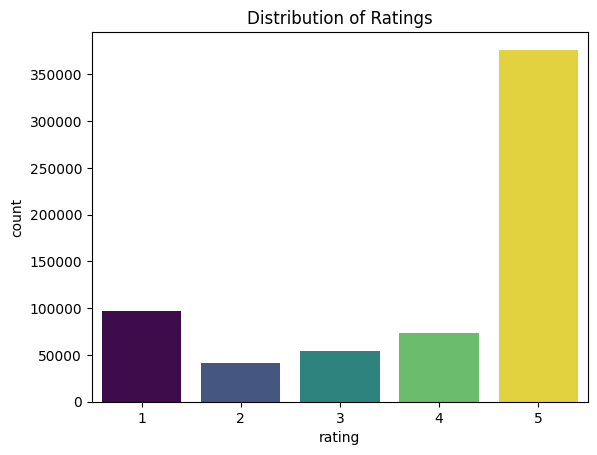

In [240]:
sns.countplot(x='rating', 
              data=df, 
              palette='viridis', 
              hue='rating')
plt.title("Distribution of Ratings")
#remove legend
plt.legend().remove()
plt.show()


We can see from the analysis above that the classes are unbalanced. We have many more evaluations with a `rating` of 5 than lower ones. We will need to use balancing techniques when we create the models.

In [241]:
# creating column 'sentiment' based on the 'rating' column
def categorize_sentiment(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'
df['sentiment'] = df['rating'].apply(categorize_sentiment)
df['sentiment'].value_counts()

sentiment
positive    450378
negative    139169
neutral      54082
Name: count, dtype: int64

### 2.3: Text Columns Analysis

#### 2.3.1: Review lenght

In [242]:
# Creating a new column 'review_length' to store the length of each review in terms of number of words
df['review_length'] = df['text'].apply(
    lambda x: len(x.split())
    )

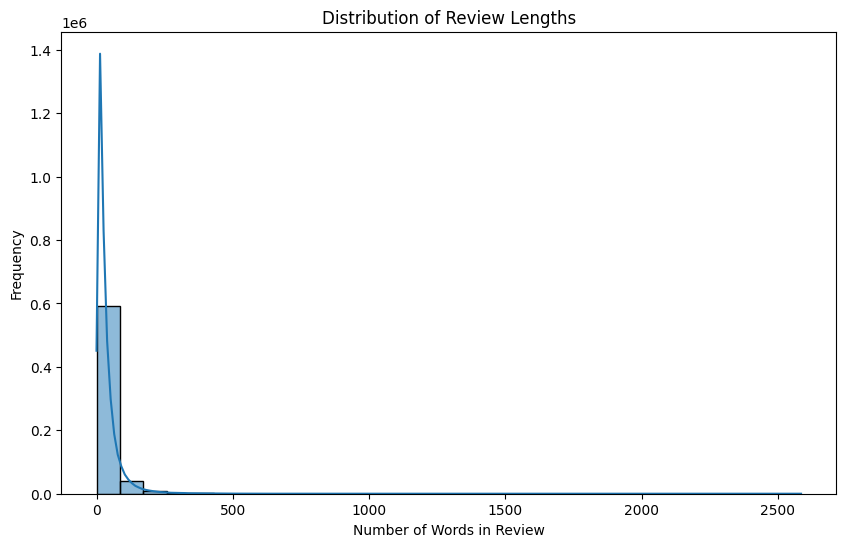

In [243]:
# creating histogram to visualize the distribution of review lengths
plt.figure(figsize=(10,6))
sns.histplot(df['review_length'], bins=30, kde=True)
plt.title("Distribution of Review Lengths")
plt.xlabel("Number of Words in Review")
plt.ylabel("Frequency")
plt.show()

In [244]:
# Token Average by review
print(f"The average number of words per review is {df['review_length'].mean():.2f} words.")

The average number of words per review is 35.14 words.


In [245]:
df.review_length.describe()

count    643629.000000
mean         35.139217
std          46.888798
min           0.000000
25%          10.000000
50%          21.000000
75%          42.000000
max        2585.000000
Name: review_length, dtype: float64

#### 2.3.2: Words most used

C:\Users\vanes\AppData\Local\Temp\ipykernel_4736\3450959012.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette="viridis")


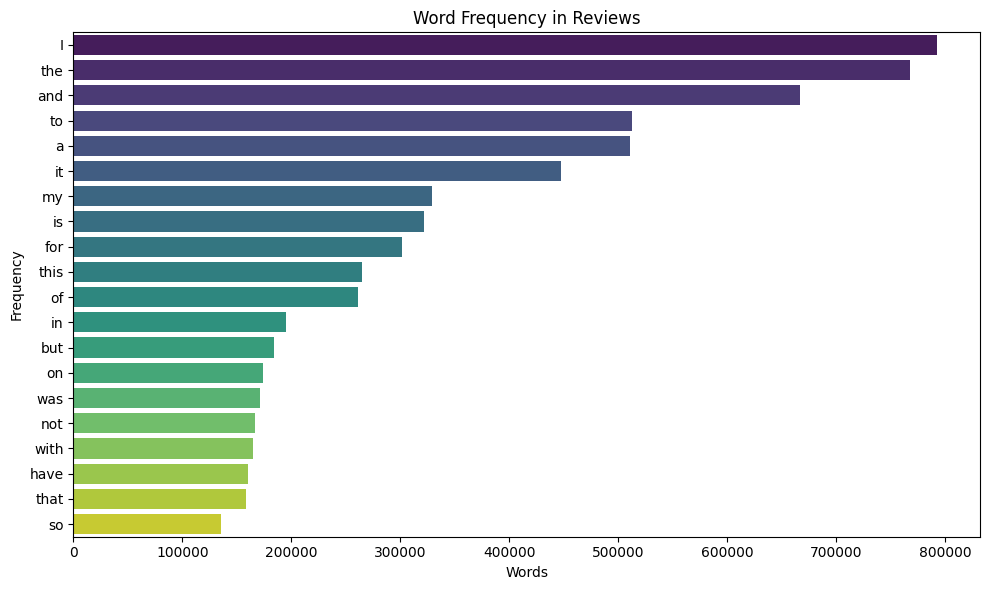

In [246]:

words = ' '.join(str(review) for review in df['text'].dropna()).split()
word_freq = Counter(words)
common_words = word_freq.most_common(20) # 20 palavras mais frequentes


words, counts = zip(*common_words)
plt.figure(figsize=(10, 6))
sns.barplot(x=counts, y=words, palette="viridis")
plt.title('Word Frequency in Reviews')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

We have checked above that the average number of words used in the reviews is 35 words and that 75% of the reviews have up to 42 words. However, there are some reviews that contain many words. Let's check the most used words and clean them up for a more detailed analysis.

#### 2.3.3: Relationship Analysis

Let's analyse if there is a relationship between the rating length and the rating given by user.

C:\Users\vanes\AppData\Local\Temp\ipykernel_4736\118814669.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='rating', y='review_length', data=df, palette='viridis')


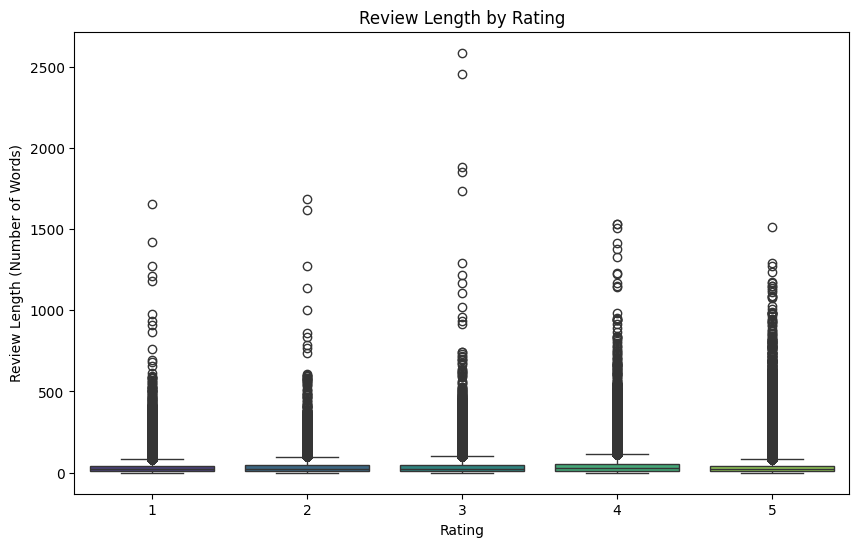

In [247]:
# creating a boxplot to visualize the distribution of review lengths by sentiment
plt.figure(figsize=(10,6))
sns.boxplot(x='rating', y='review_length', data=df, palette='viridis')
plt.title('Review Length by Rating')
plt.xlabel('Rating')
plt.ylabel('Review Length (Number of Words)')
plt.show()


The graph above shows that the number of words varies, regardless of the rating given. In other words, we cannot find a very direct relationship between the score and the length of the evaluation.

### 2.4: Temporal Analysis

In [248]:
df.columns

Index(['rating', 'title', 'text', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase', 'has_image',
       'sentiment', 'review_length'],
      dtype='object')

Let's check now if the grading pattern has changed over time. This is useful for us to identify assessment trends over the years.

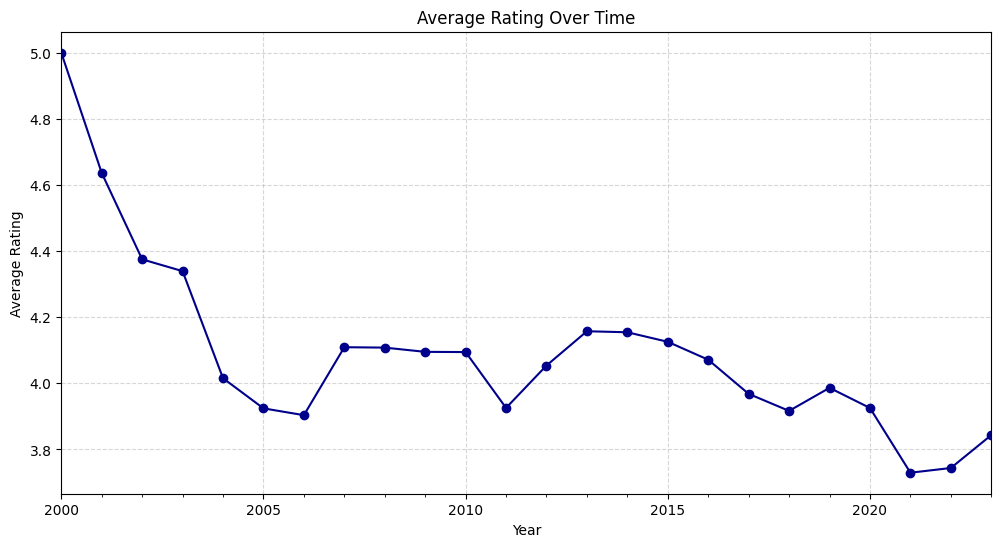

In [249]:
# creating line plot
plt.figure(figsize=(12,6))
df.set_index("timestamp").resample("YE")["rating"].mean().plot(color="darkblue", marker='o', linestyle='-', xlim=('2000', '2023'))
plt.title("Average Rating Over Time")
plt.xlabel("Year")
plt.ylabel("Average Rating")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

The graph shows us a drastic drop in the average ratings from 2000 to 2005, with a certain stabilization in the ratings between 2005 and 2020, where the ratings were contained within the range of 3.8 and 4.2. 

Since 2020, we see a downward trend where the ratings fell below the threshold of 3.8 for the first time.This indicates that the quality of the service, platform, or products has been declining over time.

### 2.5. Bivariate Analysis

Let's do a practical analysis to understand if the auxiliary column has_image really has relevance for sentiment classification. The idea is to check if there is a statistical relationship or clear trend between having images and the sentiment of the review.

In [250]:
df.has_image.value_counts()

has_image
0    586297
1     57332
Name: count, dtype: int64

In [251]:
# checking the relationship between having images and sentiment (proportion of reviews with images by sentiment)

df.groupby('sentiment')['has_image'].value_counts(normalize=True).unstack()


has_image,0,1
sentiment,,
negative,0.920852,0.079148
neutral,0.928978,0.071022
positive,0.905688,0.094312


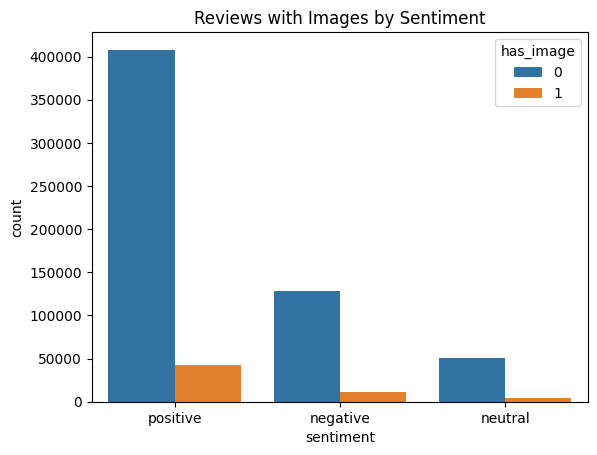

In [252]:
# visualization of the relationship between having images and sentiment
sns.countplot(x='sentiment', hue='has_image', data=df)
plt.title("Reviews with Images by Sentiment")
plt.show()


To identify whether the column is significant or not, we must perform a hypothesis test. Visually, it is not clear if there is an impact on sentiment.

* Distribution of Verified Purchases by Sentiment

In [253]:
# Converter em binário (0 = não verificado, 1 = verificado)
df['verified_purchase_flag'] = df['verified_purchase'].astype(int)
df['verified_purchase_flag'].value_counts()

verified_purchase_flag
1    579964
0     63665
Name: count, dtype: int64

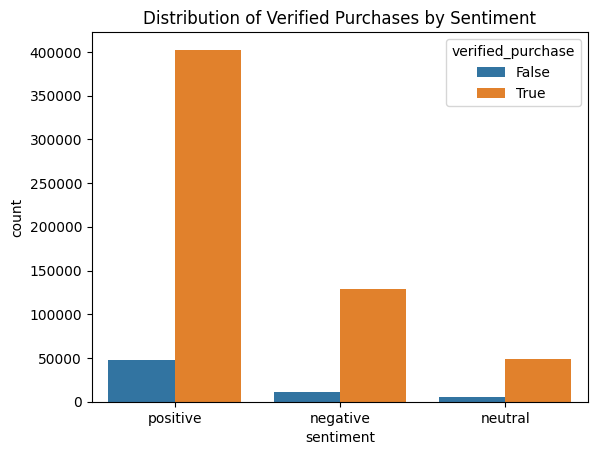

In [254]:
sns.countplot(x='sentiment', hue='verified_purchase', data=df)
plt.title("Distribution of Verified Purchases by Sentiment")
plt.show()

In [255]:
df.groupby('verified_purchase')['rating'].mean()


verified_purchase
False    4.061541
True     3.900989
Name: rating, dtype: float64

* **Average rating for unverified reviews (`False`)**: 4.06 
* **Average rating for verified reviews (`True`)**: 3.90 
--- 

**Interpretation:** 

1. **Verified reviews have, on average, a slightly lower rating**: 
    * This may indicate that users who actually purchase are slightly more critical. 

    * Unverified reviews tend to be a bit more positive, perhaps because some evaluations come from people who did not buy or who want to inflate the rating.

 2. **The difference is small (~0.16 points)**: 
 
     * It's not huge, but it can still have some value for the model. 
 
    *  The model can learn subtle patterns, especially if combined with other features (text, helpful_vote, user_avg_rating). 
 
 3. **Conclusion for the feature**: 
 
     * **It's worth keeping `verified_purchase_flag` as a binary feature** in the model. 
 

#### 2.5.1 Hypothesis Test:

##### 2.5.1.1: Is there an association between reviews with images and the sentiment of the evaluation?

**Hypothesis**

- Null hypothesis (H₀): There is no significant relationship between has_image and sentiment → the presence of images does not influence sentiment.

- Alternative hypothesis (H₁): There is a significant relationship between has_image and sentiment → the presence of images influences sentiment.

**Decision criterion**

- If p-value < 0.05 → we reject H₀ → has_image is potentially relevant.

- If p-value ≥ 0.05 → we do not reject H₀ → has_image probably does not contribute.

In [256]:
contingency_table = pd.crosstab(df['sentiment'], df['has_image'])

# chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi2 Statistic: {chi2:.2f}")
print(f"Degrees of Freedom: {dof}")
print(f"P-value: {p}")

# Interpretation
if p < 0.05:
    print("\nResults: We reject the null hypothesis. There is evidence of an association between having images and the sentiment of the review.")
else:
    print("\nResults: We fail to reject the null hypothesis. There is not enough evidence of an association between having images and the sentiment of the review.")

Chi2 Statistic: 538.46
Degrees of Freedom: 2
P-value: 1.189159118371913e-117

Results: We reject the null hypothesis. There is evidence of an association between having images and the sentiment of the review.


In [257]:
import numpy as np

# 7️⃣ Cálculo de Cramér's V (força da associação)
n = contingency_table.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape)-1)))
print(f"Cramér's V: {cramers_v:.3f}")

# 8️⃣ Interpretação de Cramér's V
if cramers_v < 0.1:
    strength = "Negligible association"
elif cramers_v < 0.3:
    strength = "Weak association"
elif cramers_v < 0.5:
    strength = "Moderate association"
else:
    strength = "Strong association"

print(f"Strength of association: {strength}")

Cramér's V: 0.029
Strength of association: Negligible association


After all the teste we can conclude:

* The **p-value < 0.05** indicates that there is a statistically significant association between `has_image` and sentiment.

* However, **Cramér's V = 0.029** shows that the **strength of this association is negligible**.

* In practice, even though it is significant, the column **does not add relevant information** to the sentiment classification model.

**Conclusion:** `has_image` probably **does not need to be included** as a feature in the model.

##### 2.5.1.2: Is the difference in average rating between verified and non-verified reviews statistically significant?

In [258]:
verified_ratings = df[df['verified_purchase']==True]['rating']
non_verified_ratings = df[df['verified_purchase']==False]['rating']

t_stat, p_val = ttest_ind(verified_ratings, non_verified_ratings)
print("p-value:", p_val)
if p_val < 0.05:
    print("We reject the null hypothesis. There is a significant difference in average ratings between verified and non-verified purchases.")
else:
    print("We fail to reject the null hypothesis. There is no significant difference in average ratings between verified and non-verified purchases.")  

p-value: 7.440442757017917e-143
We reject the null hypothesis. There is a significant difference in average ratings between verified and non-verified purchases.


## 3. Processing Text

Before proceeding with text processing, we will balance the dataset, as we have three classes with different distributions (positive, neutral, and negative). To facilitate this balancing, we will use undersampling, since we have sufficient data.

Using the **`RandomUnderSampler`**, we will **balance the classes of the dataset** by randomly reducing the larger classes to the size of the smallest class.

This practically means that:

* Previously, we had three classes with very different counts: positive (450k), negative (139k), and neutral (54k).

* By applying the `RandomUnderSampler`, the **larger classes were randomly “cut”** to match the size of the smallest class.

* The result is a **balanced dataset**, which helps machine learning models not to be biased towards the majority class.In other words: **we kept all the data from the smallest class and randomly reduced the data from the larger classes to balance the distribution of classes**.

Althoght to apply this strategy we will slipt the dataset between train and test to avoid data leakage.

In [259]:
# splitting the dataset into features and target
X = df.drop(columns=['sentiment'])
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,      # mantém proporção original das classes
    random_state=42
)

print("Original Distribution:")
print(y.value_counts())
print("\nTrain Distribution (before balancing):")
print(y_train.value_counts())
print("\nTest Distribution (original):")
print(y_test.value_counts())

Original Distribution:
sentiment
positive    450378
negative    139169
neutral      54082
Name: count, dtype: int64

Train Distribution (before balancing):
sentiment
positive    360302
negative    111335
neutral      43266
Name: count, dtype: int64

Test Distribution (original):
sentiment
positive    90076
negative    27834
neutral     10816
Name: count, dtype: int64


#### 3.1. Balancing: undersampling

In [260]:
# balancing the training set using undersampling
rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

print("\nTrain Distribution (after balancing):")
print(y_train_res.value_counts())


Train Distribution (after balancing):
sentiment
negative    43266
neutral     43266
positive    43266
Name: count, dtype: int64


In [261]:
#concat the X and y training sets after balancing
df_train = pd.concat([X_train_res, y_train_res], axis=1)

#concat the X and y test sets
df_test = pd.concat([X_test, y_test], axis=1)

Now, we need to process the text columns (`reviews`) to remove stopwords and pontuations. Left only lemma format and create new columns with this data processed.

In [ ]:
# Download the NLTK tokenizer model
# Required for the word_tokenize() function to split sentences into words.
nltk.download('punkt')

# Download the list of English stopwords
# Common words like "the", "is", "and" that are usually removed during text preprocessing.
nltk.download('stopwords')

# Download the punkt_tab tokenizer (optional)
# It's an additional resource for sentence tokenization.
# Usually 'punkt' is enough, but this can prevent some rare errors.
nltk.download('punkt_tab')

# Download the WordNet lexical database
# Required for WordNetLemmatizer to reduce words to their base/root form.
nltk.download('wordnet')

# Download the Open Multilingual WordNet (OMW) package
# Provides extended support for lemmatization and improves accuracy.
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vanes\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vanes\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\vanes\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vanes\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\vanes\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
# defining list of stopwords
stopwords = set(nltk.corpus.stopwords.words('english'))

# punctuation list
punctuations = string.punctuation
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\vanes\AppData\Roaming\nltk_data...


### 3.1: Tokenization

In [264]:
def clean_text_nltk(text):
    """Clean the input text by removing stopwords and punctuation, and converting to lowercase.
    
    Args:
        text (str): The input text to be cleaned.
    Returns:
        list: The cleaned text.
    """
    if pd.isnull(text):
        return []
    
    # Remove all characters that are not letters or numbers
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)
    
    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords and punctuation, convert to lowercase and lemmatize
    cleaned_tokens = [
        lemmatizer.lemmatize(word.lower())
        for word in tokens
        if word.lower() not in stopwords and word.strip() != ""
    ]
    
    return cleaned_tokens

### 3.2: Lemmatization

In [265]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ------------- -------------------------- 4.5/12.8 MB 38.1 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 40.1 MB/s  0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
# load the spaCy model for lemmatization
nlp = spacy.load('en_core_web_sm')

In [267]:
def clean_text_spacy(text):
    """Clean the input text by removing stopwords and punctuation, and converting to lowercase.
    Args:
        text (str): The input text to be cleaned.
    Returns:
        list: The cleaned text.
    """
    if pd.isnull(text):
        return []
    
    doc = nlp(text)
    cleaned_tokens = [
        token.lemma_.lower() for token in doc
        if not token.is_stop and not token.is_punct and not token.is_space
    ]
    # Remove all characters that are not letters or numbers
    final_tokens = [re.sub(r"[^a-zA-Z0-9]", "", token) for token in cleaned_tokens]
    final_tokens = [token for token in final_tokens if token]  # remove empty tokens

    return final_tokens


In [268]:
def apply_pipeline(df, text_column='text'):
    """Apply text cleaning pipeline to a DataFrame column.
    
    Args:
        df (pd.DataFrame): The input DataFrame.
        text_column (str): The name of the column containing text data.
    Returns:
        pd.DataFrame: The DataFrame with an additional column for cleaned text.
    """
    df['token_nltk'] = df[text_column].apply(clean_text_nltk)
    df['token_spacy'] = df[text_column].apply(clean_text_spacy)

    return df

In [273]:
# apply the text cleaning pipeline
df_train_cleaned = apply_pipeline(df_train)

In [274]:
df_test_cleaned = apply_pipeline(df_test)

In [275]:
#visualizing the cleaned text
df_train_cleaned[['text', 'token_nltk', 'token_spacy']].head()

,text,token_nltk,token_spacy
634685,Do not waste your money. I opened the package ...,"[waste, money, opened, package, charged, direc...","[waste, money, open, package, charge, direct, ..."
431812,I did not like that product did not work as sh...,"[like, product, work, showed, unhappy]","[like, product, work, show, unhappy]"
464069,Nice looking product. Just doesn't do its job....,"[nice, looking, product, job, order, different...","[nice, look, product, job, order, different, p..."
578273,The scent is gone in less than a minute..waste...,"[scent, gone, less, minute, waste, money, never]","[scent, go, minute, waste, money]"
566486,Horrible colors. Not as pictured. Don't waste ...,"[horrible, color, pictured, waste]","[horrible, color, picture, waste]"


In [276]:
#visualizing the cleaned text (test set)
df_test_cleaned[['text', 'token_nltk', 'token_spacy']].head()

,text,token_nltk,token_spacy
146177,Excellent Brush!,"[excellent, brush]","[excellent, brush]"
687501,Gives me a great Tan. And leaves a great scent.,"[give, great, tan, leaf, great, scent]","[give, great, tan, leave, great, scent]"
594299,I really like the lashes. Would love more colors,"[really, like, lash, would, love, color]","[like, lash, love, color]"
440087,The pieces that were able to be put together s...,"[piece, able, put, together, stretch, 7, 8, in...","[piece, able, stretch, 7, 8, inch, suppose, st..."
349196,Very soft and convenient!!!,"[soft, convenient]","[soft, convenient]"


In [277]:
df_train_cleaned.columns

Index(['rating', 'title', 'text', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase', 'has_image',
       'review_length', 'verified_purchase_flag', 'sentiment', 'token_nltk',
       'token_spacy'],
      dtype='object')

In [278]:
# counting the number of tokens in each review (training set)
df_train_cleaned['n_tokens_nltk'] = df_train_cleaned['token_nltk'].apply(len)
df_train_cleaned['n_tokens_spacy'] = df_train_cleaned['token_spacy'].apply(len)

#visualizing the counts
df_train_cleaned[['text', 'review_length', 'n_tokens_nltk', 'n_tokens_spacy']].head()


,text,review_length,n_tokens_nltk,n_tokens_spacy
634685,Do not waste your money. I opened the package ...,80,39,28
431812,I did not like that product did not work as sh...,13,5,5
464069,Nice looking product. Just doesn't do its job....,19,10,8
578273,The scent is gone in less than a minute..waste...,13,7,5
566486,Horrible colors. Not as pictured. Don't waste ...,9,4,4


In [279]:
# average number of tokens per review (training set)
print(f"Average number of tokens per review (NLTK): {df_train_cleaned['n_tokens_nltk'].mean():.2f}")
print(f"Average number of tokens per review (spaCy): {df_train_cleaned['n_tokens_spacy'].mean():.2f}")

Average number of tokens per review (NLTK): 17.97
Average number of tokens per review (spaCy): 15.52


The average number of tokens with NLTK is higher than that of SpaCy, indicating that NLTK performs a more detailed tokenization. This suggests that the tools may handle certain elements of the text differently, which could impact subsequent analysis.

### 3.3: Frequency Analysis and Vectorization

* **Frequency Analysis:**

In [280]:
df_train_cleaned.token_nltk

634685    [waste, money, opened, package, charged, direc...
431812               [like, product, work, showed, unhappy]
464069    [nice, looking, product, job, order, different...
578273     [scent, gone, less, minute, waste, money, never]
566486                   [horrible, color, pictured, waste]
                                ...                        
518850    [videoid, 7fd35246a6d7b0137924aa23ba2b559, worth]
84719                              [versatile, lightweight]
351996    [quite, color, pictured, gray, definitely, bro...
583199       [natural, noticeable, wearing, false, eyelash]
289081    [pretty, easy, fill, read, need, remove, chain...
Name: token_nltk, Length: 129798, dtype: object

In [281]:
# generate word clouds for the most common words in the cleaned text
complete_text = " ".join(str(token) for token in df_train_cleaned['token_nltk'])

# create a word cloud
wordcloud_nltk = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(complete_text)

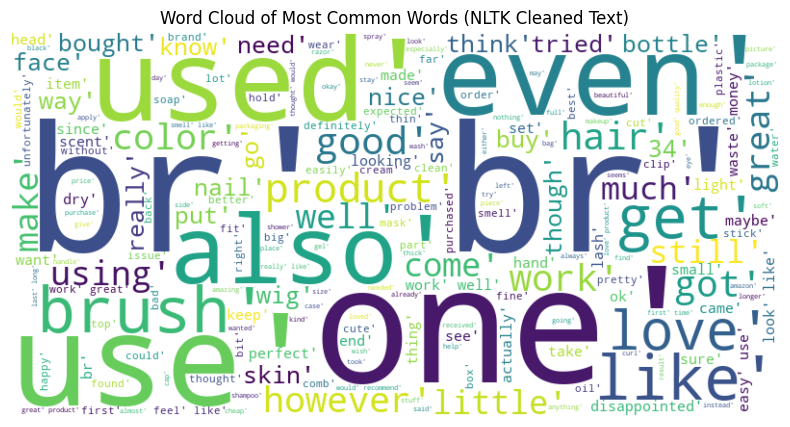

In [282]:
# plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_nltk, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Most Common Words (NLTK Cleaned Text)")
plt.show()


In [283]:
# generate word clouds for the most common words in the cleaned text
complete_text = " ".join(str(token) for token in df_train_cleaned['token_spacy'])

# create a word cloud
wordcloud_spacy = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(complete_text)

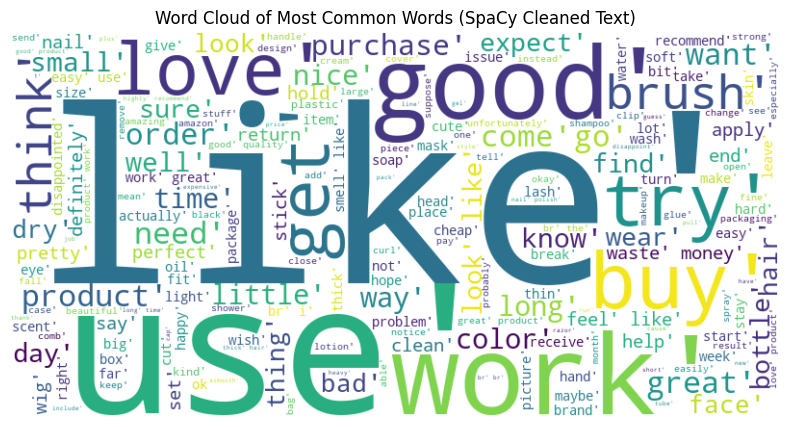

In [284]:
# plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_spacy, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Most Common Words (SpaCy Cleaned Text)")
plt.show()


C:\Users\vanes\AppData\Local\Temp\ipykernel_4736\2346596428.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette="viridis")


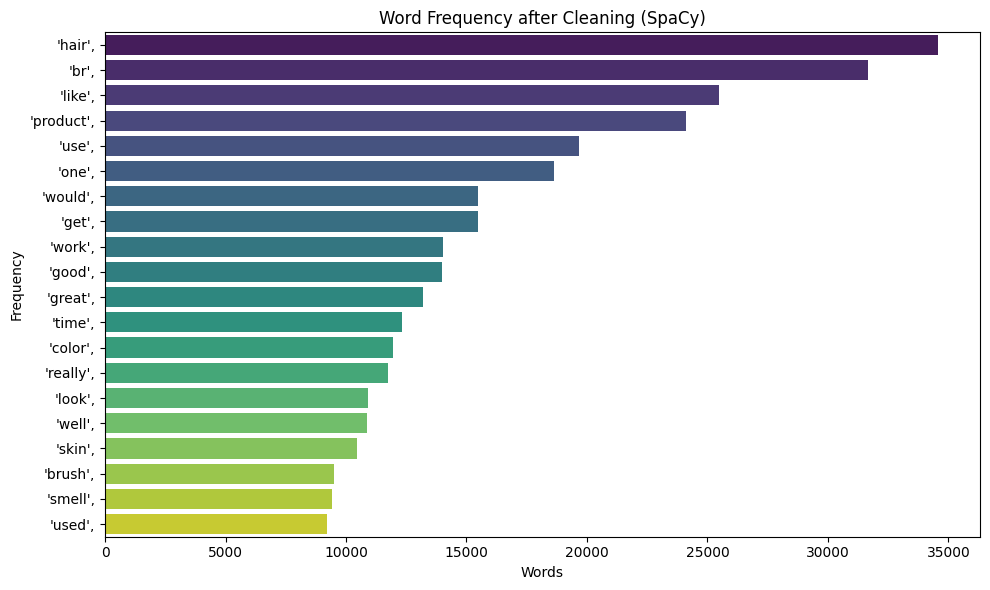

In [286]:
words = ' '.join(str(review) for review in df_train_cleaned['token_nltk'].dropna()).split()
word_freq = Counter(words)
common_words = word_freq.most_common(20) # 20 palavras mais frequentes


words, counts = zip(*common_words)
plt.figure(figsize=(10, 6))
sns.barplot(x=counts, y=words, palette="viridis")
plt.title('Word Frequency after Cleaning (SpaCy)')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

C:\Users\vanes\AppData\Local\Temp\ipykernel_4736\2709013613.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette="viridis")


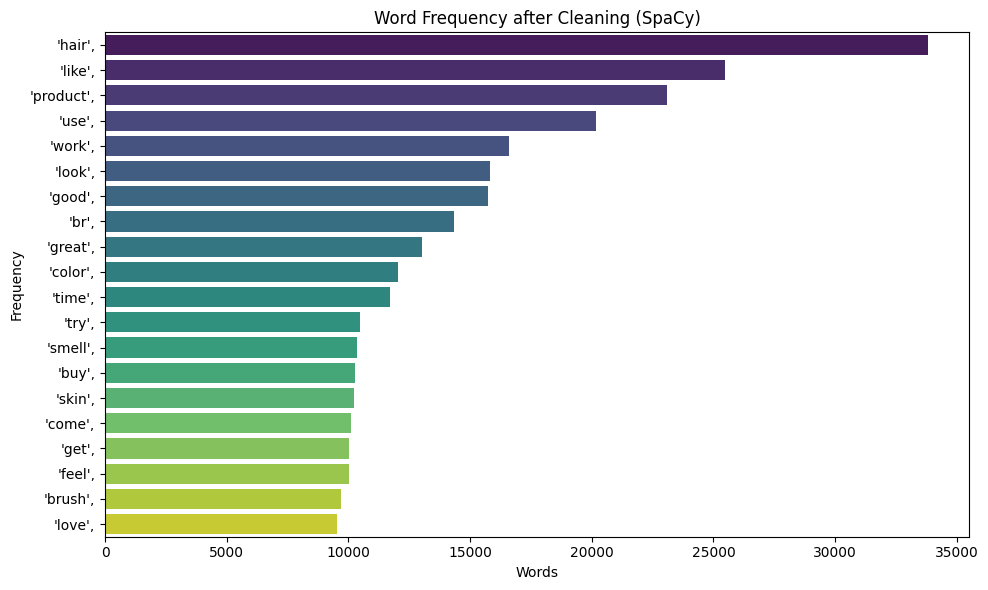

In [285]:
words = ' '.join(str(review) for review in df_train_cleaned['token_spacy'].dropna()).split()
word_freq = Counter(words)
common_words = word_freq.most_common(20) # 20 palavras mais frequentes


words, counts = zip(*common_words)
plt.figure(figsize=(10, 6))
sns.barplot(x=counts, y=words, palette="viridis")
plt.title('Word Frequency after Cleaning (SpaCy)')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()